In [1]:
import pandas as pd
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class PixelArtDataset(Dataset):
  def __init__(self):
    super(PixelArtDataset).__init__()
    
    self.load_data()
    self.transform = transforms.Compose([
        transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float16),
    ])

  def load_data(self):
    images = os.listdir("./data/images")
    meta = pd.read_parquet("./data/metadata.parquet")
    meta = meta.set_index("image_name")
    
    self.data = []
    for image in images:
      if image in meta.index:
        image_data = meta.loc[image]
        self.data.append({
          "image_path": os.path.join("./data/images", image),
          "prompt": image_data["prompt"],
          "seed": image_data["seed"],
        })

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data[idx]
    
    image = Image.open(data["image_path"]).convert("RGB")
    image = self.transform(image)
    
    return {
      "image": image,
      **{k: v for k, v in data.items() if k != "image_path"}
    }

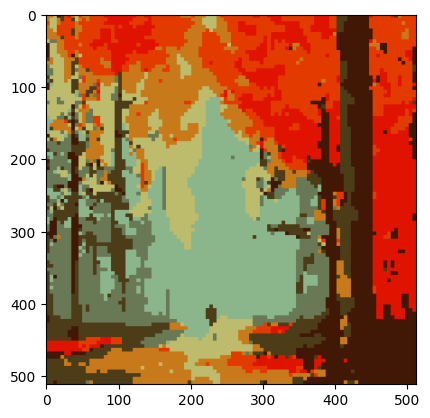

In [2]:
import matplotlib.pyplot as plt

item = PixelArtDataset()[0]
image = item["image"].permute(1, 2, 0).cpu().numpy().astype("float32")
plt.imshow(image)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(device)

cuda


In [4]:
from diffusers import StableDiffusionPipeline
from diffusers.schedulers import PNDMScheduler

pipe = StableDiffusionPipeline.from_pretrained(
    "sd-legacy/stable-diffusion-v1-5", use_safetensors=True
).to(device)

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

vae = pipe.vae
unet = pipe.unet
scheduler: PNDMScheduler = pipe.scheduler

text_encoder.eval()
vae.eval()
unet.train()
pass

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
from torch.nn.functional import mse_loss
import time

def train(dataset, optimizer):
  for epoch in range(1):
    for step, data in enumerate(dataset):
      if step > 50:
        break
      print(f"Epoch {epoch}, Step {step}, ", end="")
      
      image = data["image"].unsqueeze(0).to(device)
      prompt = data["prompt"]
      seed = data["seed"]
      
      torch.manual_seed(seed)
      
      with torch.no_grad():
        tokens = tokenizer(prompt, return_tensors="pt", max_length=tokenizer.model_max_length, padding=True, truncation=True)
        embeddings = text_encoder(tokens.input_ids).last_hidden_state
      
        latents = vae.encode(image).latent_dist.sample() * vae.config.scaling_factor
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],))
        latents = scheduler.add_noise(latents, noise, timesteps)
      
      predicted = unet(latents, timesteps, encoder_hidden_states=embeddings).sample
      
      loss = mse_loss(predicted, noise)
      
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      print(f"Loss: {loss.item()}")
    
    unet.save_pretrained(f"./checkpoints/unet_epoch_{time.strftime('%Y%m%d_%H%M%S')}_{epoch}.pt")

In [6]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-5)

In [15]:
try:
  with torch.autocast(device):
    train(PixelArtDataset(), optimizer)
except KeyboardInterrupt:
  print("Training interrupted.")
  pass

Epoch 0, Step 0, Loss: 0.06860343366861343
Epoch 0, Step 1, Loss: 0.14359499514102936
Epoch 0, Step 2, Loss: 0.20664772391319275
Epoch 0, Step 3, Loss: 0.037676647305488586
Epoch 0, Step 4, Loss: 0.003403996117413044
Epoch 0, Step 5, Loss: 0.018852900713682175
Epoch 0, Step 6, Loss: 0.1425703763961792
Epoch 0, Step 7, Loss: 0.08305507898330688
Epoch 0, Step 8, Loss: 0.18595051765441895
Epoch 0, Step 9, Loss: 0.04929276928305626
Epoch 0, Step 10, Loss: 0.009913673624396324
Epoch 0, Step 11, Loss: 0.2460351586341858
Epoch 0, Step 12, Loss: 0.0318550243973732
Epoch 0, Step 13, Loss: 0.26290959119796753
Epoch 0, Step 14, Loss: 0.03055575117468834
Epoch 0, Step 15, Loss: 0.14170628786087036
Epoch 0, Step 16, Loss: 0.1107858195900917
Epoch 0, Step 17, Loss: 0.0027068862691521645
Epoch 0, Step 18, Loss: 0.2886461019515991
Epoch 0, Step 19, Loss: 0.011716170236468315
Epoch 0, Step 20, Loss: 0.14736008644104004
Epoch 0, Step 21, Loss: 0.08320318162441254
Epoch 0, Step 22, Loss: 0.01435644179582

In [16]:
unet.save_pretrained(f"./checkpoints/unet_epoch_{time.strftime('%Y%m%d_%H%M%S')}_manual.pt")

In [12]:
unet = torch.load("checkpoints/unet_epoch_20250521_180333_manual.pt")

PermissionError: [Errno 13] Permission denied: 'checkpoints/unet_epoch_20250521_180333_manual.pt'

In [17]:
import numpy as np

def generate_image(prompt: str, iters: int = 100):
  with torch.no_grad(), torch.autocast(device):
    tokens = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    embeddings = text_encoder(tokens.input_ids).last_hidden_state
    
    latents = torch.randn((1, unet.config.in_channels, 512 // 8, 512 // 8))
    
    scheduler.set_timesteps(iters)
    
    for step, t in enumerate(scheduler.timesteps):
      print(f"Step {step}/{iters}")
      latent_model_input = scheduler.scale_model_input(latents, t)
      
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample
      
      latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    image = vae.decode(latents / vae.config.scaling_factor).sample
    image = (image / 2 + 0.5).clamp(0, 1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.float32)
    
    return image

Step 0/1


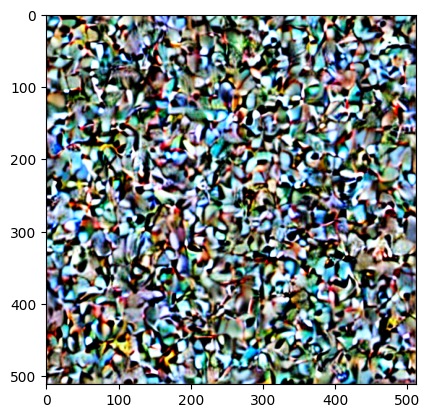

In [24]:
import matplotlib.pyplot as plt

image = generate_image("A cat between a lake and a mountain", 1)

plt.imshow(image)


In [25]:
image = Image.fromarray((image * 255).astype(np.uint8))
image = image.resize((64, 64), Image.NEAREST)
image = image.resize((512, 512), Image.NEAREST)

image.save("output.png")